In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print('Tensorflow   :', tf.__version__)

## Directory

In [ ]:
!pwd

Посмотрим на то, как строится наша дирректория на Kaggle: по умолчанию мы находимся в директории /kaggle/working. Чтобы добрать до наших данных мы должны совершить прыжок на одну директорию назад (..) и перейти в папку input, в ней и будет храниться папка с нашими данными

In [ ]:
!ls ../input/mds-misis-dl-car-classification/

Для создания генераторов нам понадобятся переменные, хранящие пути до тренировочной и тестовой выборок. Так же сохраним путь до самой папки 'mds-misis-dl-car-classification' и путь до папки, в которую мы будем сохранять веса наилучшей модели

In [ ]:
!ls ../working/

In [ ]:
TRAIN_PATH = "../input/mds-misis-dl-car-classification/train/train"
TEST_PATH = '../input/mds-misis-dl-car-classification/test/test_upload'
DATA_PATH = '../input/mds-misis-dl-car-classification/'
CHECKPOINT_PATH = 'models/'

## Global params

В качестве глобальных переменных так же будем хранить размер изображения, к которому мы будем приводить наши картинки, входнной размер сети, количество классов и зерно датчика случайных чисел

In [ ]:
IMAGE_SIZE = [250, 250]
IMAGE_CHANEL = [3]
INPUT_SHAPE = IMAGE_SIZE + IMAGE_CHANEL
CLASS_NUM = 10
RANDOM_SEED = 19812
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 32

## Functions

Создадим функции-рисовалки, которые нам в дальнейшем пригодятся

In [ ]:
def plot_sample_images(data, path_to_images, path_col='Id', class_col='Category', image_count=6):
    """
    Функция для вывода нескольких изображений на экран. 
    Пути до изображений и классы, которые им соответствуют хранятся в pd.DataFrame
    Директория с изображениями должна быть организована по принципу имя класса: изображения, соответствующее этому классу
    Аргументы:
        data -> pd.DataFrame - датафрейм в котором хранятся имена файлов и метки классов, соответствующих им
        path_to_images -> str - путь до папки, в которой хранятся изображения
        path_col -> str - имя столбца датафрейма, в котором хранятся имена файлов
        class_col -> str - имя столбца датафрейма, в которой хранятся метки классов
        image_count -> int - количество выводимых изображений
    """
    fig = plt.figure(figsize=(12, 8)) #создаем фигуру
    random_image = data.sample(n=image_count) #случайный выбор n строк из таблицы
    random_image_paths = random_image[path_col].values #пути до файлов
    random_image_cat = random_image[class_col].values #метки классов

    for index, path in enumerate(random_image_paths): #цикл по пронумерованным путям
        class_label = str(random_image_cat[index])
        img = tf.keras.preprocessing.image.load_img(os.path.join(path_to_images, class_label, path)) #читаем изображение
        plt.subplot(3, 3, index + 1) # добавляем холст для вывода изображений
        plt.imshow(img) #вывод изображения на экран
        plt.title('Class: ' + str(random_image_cat[index])) #даем название холсту
        plt.axis('off') #отключаем оси
    plt.show() 

In [ ]:
def plot_sample_images_generator(generator, count_images=6):
    """
    Функция для вывода нескольких изображений на экран
    Изображения задаются из генератора изображений tensorflow
    Аргументы:
        generator -> tensorflow.keras.preprocessing.image.ImageDataGenerator - генератор изображений
        count_images -> int - количество выводимых изображений
    """
    x, y = generator.next() #получаем batch изображений из генератора: 
    #x - тензор размера (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE) 
    #y - вектор размера BATCH_SIZE
    fig = plt.figure(figsize=(30, 10)) #создаем фигуру
    for i in range(count_images): #цикл по индексам изображений
        image = x[i] #достаем iое изображение
        plt.subplot(3, 3, i + 1) #добавляем холст
        plt.imshow(image) #выводим изображение
        plt.title('Class: ' + str(y[i])) #даем название холсту
    plt.show()

In [ ]:
def plot_history(history):
    """
    Функция для вывода графиков обучения
    Аргументы:
        history - история обучения, полученная из метода fit модели keras
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].plot(history.history['accuracy'])
    axes[0].plot(history.history['val_accuracy'])
    axes[0].set_title('Model accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Train', 'Test'])

    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    axes[1].set_title('Model loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Train', 'Test'])
    plt.show()

In [ ]:
def plot_classes_balance(data, class_col = 'Category'):
    """
    Функция для вывода баланса классов в виде bar-диаграммы
    Аргументы:
        data -> pd.DataFrame - датафрейм, содержащий метки классов
        class_col -> str - имя столбца с метками классов
    """
    fig = plt.figure(figsize=(12, 8))
    percentage_data = data[class_col].value_counts(normalize=True).rename('percentage').reset_index()
    sns.barplot(x='index', y='percentage', data=percentage_data)

## Load data

Прочитаем файлы, которые нам даны по условию задачи

In [ ]:
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
print(os.path.join(DATA_PATH, 'train.csv'))
print(f'Shape: {train_df.shape}')
train_df.head()

In [ ]:
submission = pd.read_csv(os.path.join(DATA_PATH, 'sample-submission.csv'))
print(f'Shape: {submission.shape}')
submission.head()

## Show images and grafic

Посмотрим на наши изображения. Напомню, что путь до папки с изображениями хранится в переменной TRAIN_PATH. Выводить изображения будем с помощью написанной выше функции plot_sample_images

In [ ]:
plot_sample_images(data=train_df, path_to_images=TRAIN_PATH)

Убедимся, что наши классы сбалансированы. Для этого выведем график процентного соотношения классов с помощью функции plot_classes_balance

In [ ]:
plot_classes_balance(data=train_df)

## Data Generator

В двух предыдущих соревнованиях данные подавались в формате csv или же в формате np, в которых полностью хранились изображения. Однако в данном случае хранить в памяти компьютера 15к изображений размера (250, 250), как минимум, безумная идея. Было бы хорошо, иметь инструмент, который бы выдавал нам изображения определенными заданными нами порциями. Такой инструмент есть в keras - это класс **ImageDataGenerator**. <p>
Помимо того, что данный класс позволяет вызывать методы, которые могут создавать генератор из датафрейма с именами файлов (flow_from_dataframe) или из дирректории (flow_from_directory), он так же позволяет очень просто организовывать аугметацию данных и их предобработку: отмасштабировать изображения и привести их к заданному размеру <p>
Документация: https://keras.io/api/preprocessing/image/ <p>
Полезная статья по параметрам: http://www.100byte.ru/python/imgGenerator/imgGenerator.html


Для того, чтобы сгенерировать данные необходимо для начала объявить объект класса ImageDataGenerator и передать в него параметры

In [ ]:
train_datagen = ImageDataGenerator( 
    rotation_range=15, #диапазон изображения в градусах
    width_shift_range=0.1, #смещение изображения по ширине
    height_shift_range=0.1, #смещение изображения по высоте
    brightness_range=[0.8, 1.3], #предел изменения яркости изображения
    zoom_range=0.2, #коэффициент приближения и отдаления изображения
    horizontal_flip=True, #зеркальное отображение по горизонтали
    vertical_flip=False, #зеркальное отображение по вертикали
    rescale=1/255, #масштабирование изображений
    preprocessing_function=None, #дополнительные функции для пользовательского препроцессинга
    validation_split=VALIDATION_SPLIT, #размер валидационной выборки
)

Однако для тестовой выборки, как известно, агментация ни к чему. Поэтому для нее необходимо создание отдельного генератора

In [ ]:
test_datagen = ImageDataGenerator(rescale=1/255)

Теперь, когда классы генераторов проинициализированы можно передавать в них наши данные. В нашей задаче обучающая выборка представлена в виде директории, которую мы обозвали TRAIN_PATH, организованной следующим образом: в ней хранятся 10 папок, имена которых соответствуют меткам классов (от 0 до 10). В каждой из таких папок хранятся изображения соответствующего класса. <p>
Для директорий, организованных по такому принципу, существует легкий способ создать генераторы с помощью метода flow_from_directory <p>
Также помним о том, что как такого валидационной выборки у нас нет, поэтому небходимо создать для нее отдельный генератор 

In [ ]:
train_ds = train_datagen.flow_from_directory(
    directory=TRAIN_PATH, # путь до директории
    shuffle=True, #перемешивать ли данные
    target_size=IMAGE_SIZE, #целевой размер изображений на выходе генератора
    batch_size=BATCH_SIZE, #размер батча
    seed=RANDOM_SEED, #зерно датчика случайных чисел
    class_mode='categorical', #какого типа классы изображений
    subset='training' #указываем, что выборка тренировочная
)

val_ds = train_datagen.flow_from_directory(
    directory=TRAIN_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True, 
    seed=RANDOM_SEED,
    class_mode='categorical', 
    subset='validation' #указываем, что выборка валидационная
)

Тестовые же данные организованы совсем по иному принципу: у нас есть дирректория TEST_PATH, в которой в одной куче хранятся изображения, для которых необходимо получить предсказание. Имена этих изображений хранятся в файле sample-submissin.csv. Но у генератора из keras найдется ответ и на такой случай: метод flow_from_dataframe принимает в себя dataframe, в которым содержатся имена файлов с изображениями 

In [ ]:
test_ds = test_datagen.flow_from_dataframe(
    dataframe=submission,
    directory=TEST_PATH,
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

## Simple Model

Перейдем к созданию архитектуры модели

In [ ]:
n_conv_blocks = 6 #количество сверточных блоков
n_dense_blocks = 2 #количество полносвязных блоков
model = Sequential()
model.add(tf.keras.Input(INPUT_SHAPE))
for i in range(1, n_conv_blocks+1):
    model.add(layers.Conv2D(32*i, 
                            kernel_size=(3, 3), 
                            activation = None, 
                            padding='same')),
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Conv2D(64*i, 
                            kernel_size=(3, 3), 
                            activation = None, 
                            padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Conv2D(64*i, 
                            kernel_size=(3, 3), 
                            activation = None, 
                            padding='same'))
    model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
for i in range(1, n_dense_blocks+1):
    model.add(layers.Dense(256*i, kernel_initializer=initializers.GlorotNormal()))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.2*i))
model.add(layers.Dense(CLASS_NUM, activation='softmax'))
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True)

In [ ]:
initial_learning_rate = 0.01 #начальный learning rate
model.compile(
    loss = "categorical_crossentropy", #функция потерь
    optimizer = optimizers.Adam(lr=initial_learning_rate), #оптимизатор
    metrics=['accuracy'] #метрики
)

In [ ]:
def lr_exp_decay(epoch, lr):#функция экпоненциального уменьшения learning rate
    k = 0.1 
    return initial_learning_rate * np.exp(-k*epoch)
callbacks_list = [
    callbacks.ReduceLROnPlateau( #уменьшение lr при "застопорении" обучения
        monitor = 'val_loss', #за изменением какой метрики мы будем следить ('val_accuracy')
        patience = 2, #через сколько эпох сработает callback
        verbose = 1, #частота вывода работы callback'a
        factor = 0.1, #фактор уменьшения learning rate
        min_lr=1e-7), #минимально возможный learning rate
    callbacks.EarlyStopping( #ранняя остановка
        monitor = 'val_loss', 
        patience = 5,
        verbose = 1), 
    callbacks.ModelCheckpoint(
        filepath=CHECKPOINT_PATH + '/simple_best_model.hdf5', #путь до сохраняемой модели 
        monitor='val_loss', 
        verbose=1, 
        save_best_only=True),#сохраняем только лучшие веса
    callbacks.LearningRateScheduler(
        lr_exp_decay, #функция по законам которой изменяется learning rate
        verbose=1 
    )
]

In [ ]:
epochs=5 #количество эпох
history = model.fit(
    train_ds,
    validation_data = val_ds, 
    epochs = epochs,
    callbacks=callbacks_list,
    batch_size = BATCH_SIZE,
)

In [ ]:
model.load_weights('models/simple_best_model.hdf5')

Как видно, наша простая модель не обладает сильной предсказательной способностью. Мы вполне могли бы еще поколдовать с ней и получить что-то более стоющее, например: можно поиграться с параметрами аугметрации,менять количество слоев в сети, количество нейронов, вводить другие функции активации, менять learning_rate, добавлять Callback'и или полностью менять архитектуру <p>

## Transfer Learning

Однако есть другой вариант - это использование уже готовых архитектур сетей. Такой прием именуется как Transfer Learning (перенос обучения) и позволяет применять уже предобученные на других задачах архитектуры

In [ ]:
from tensorflow.keras.applications import MobileNetV2, DenseNet201, ResNet50 #испорт различных архитектур

### Dense Net (201)

Сегодня мы будем использовать архитектуру DenseNet.
Ссылка на официальную реализацию в Keras: https://github.com/titu1994/DenseNet

Основные особенности архитектуры:
*     Сеть состоит из «dense» блоков (4ех)
*     Темп роста сети (количество сверточных блоков в 1ом dense блоке) регулирует, сколько новой информации каждый слой вносит в глобальное состояние сети
*     Конкатенация результатов работы предыдущих слоев в блоке
*     Небольшое количество параметров по сравнению с другими архитектурами
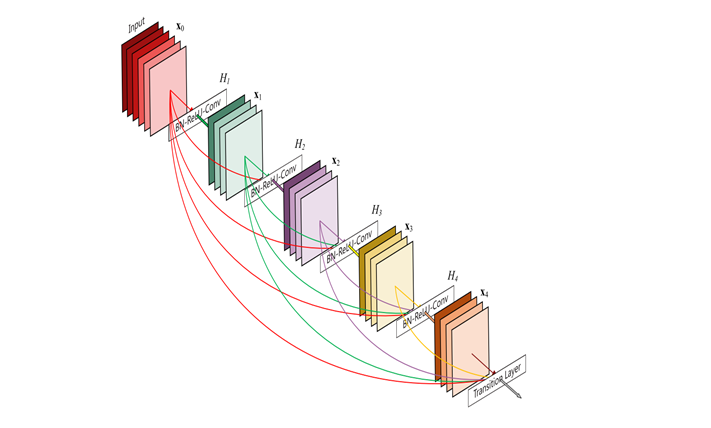
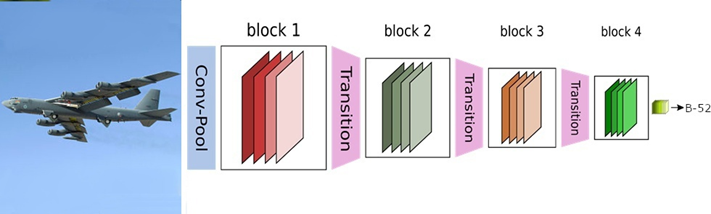


Для начала загрузим архитектуру DenseNet из keras и возьмем из нее только сверточные слои. При этом веса будем использовать те, которые модель получила, обучаясь на задаче ImageNet

In [ ]:
base_model = DenseNet201(
    weights='imagenet', #указываем какие веса мы будем брать
    input_shape=INPUT_SHAPE, #по умолчанию размер изображений - (224, 224)
    include_top=False #мы берем только сверточные слои(тело), полносвязные (голову) отрезаем
)
base_model.summary()

In [ ]:
len(base_model.layers)

In [ ]:
#tf.keras.utils.plot_model(base_model, show_shapes = True)

In [ ]:
model = Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation=None, kernel_initializer=initializers.GlorotNormal()))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(0.2))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation=None, kernel_initializer=initializers.GlorotNormal()))
model.add(layers.LeakyReLU(0.2))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(CLASS_NUM, activation='softmax'))
model.summary()

In [ ]:
def lr_exp_decay(epoch, lr):
    k = 0.1
    return initial_learning_rate * np.exp(-k*epoch)
callbacks_list = [
    callbacks.ReduceLROnPlateau(
        monitor = 'val_loss', 
        patience = 2, 
        verbose = 1, 
        min_lr=1e-7), 
    callbacks.EarlyStopping(
        monitor = 'val_loss', 
        patience = 5,
        verbose = 1, 
        restore_best_weights = True), 
    callbacks.ModelCheckpoint(
        filepath=CHECKPOINT_PATH + '/transfer_best_model.hdf5', 
        monitor='val_loss',
        verbose=1, 
        save_best_only=True),
    callbacks.LearningRateScheduler(
        lr_exp_decay, 
        verbose=1
    )
]

In [ ]:
initial_learning_rate = 0.001
model.compile(
    loss = "categorical_crossentropy", 
    optimizer = optimizers.Adam(lr=initial_learning_rate), 
    metrics=['accuracy']
)

In [ ]:
epochs=5
history = model.fit(
        train_ds,
        validation_data = val_ds, 
        epochs = epochs,
        callbacks=callbacks_list,
        batch_size = BATCH_SIZE)
plot_history(history)

Очевидно, что данная архитектура превосходит все наши ожидания. Сохраним полученные веса модели:

In [ ]:
model.load_weights(CHECKPOINT_PATH + '/transfer_best_model.hdf5')

**Способы улучшить нашу модель**: поставить большее количество эпох, произвести fine tunning модели, поиграться с количестом нейронов в полносвязных слоях, ввести другие функции активации<p>
Ссылка на статью об интересном семействе активационных функций tanhsoft: https://deepai.org/publication/tanhsoft-a-family-of-activation-functions-combining-tanh-and-softplus

## Submit

In [ ]:
train_ds.class_indices

In [ ]:
predictions = model.predict(test_ds, verbose=1) #предсказываем вероятности принадлежности классов для каждого изображения из test_ds
predictions = np.argmax(predictions, axis=-1) #берем индекс наибольшего значения этих вероятностей
predictions

In [ ]:
label_map = (train_ds.class_indices) #получаем словарь соответствия меток классов и самих классов
label_map = dict((v,k) for k,v in label_map.items()) #меняем местами ключи и значения в этом словаре
predictions = [label_map[k] for k in predictions] #перекодируем наше предсказание

In [ ]:
test_submission = submission.copy()
test_submission['Category'] = pd.Series(predictions)
test_submission.to_csv('submission.csv', index=False)
print('Save submit')